#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18B Forecasting a home price index**

using case-schiller-la dataset

version 1.0 2021-05-05

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from datetime import datetime
import sys
import statsmodels
import patsy
import pmdarima
import statsmodels.formula.api as smf
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
data_in = os.path.join(str(base_dir), "da_data_repo/case-shiller-la/clean/")
data_out = os.path.join(str(base_dir), "da_data_repo/ch18-case-shiller-la/")
output = os.path.join(data_out, "output")
func = os.path.join(str(base_dir), "da_case_studies/ch00-tech-prep/")

In [5]:
sys.path.append(func)
from py_helper_functions import *

In [6]:
csv_path = os.path.join(data_in,"homeprices-data-2000-2018.csv")
data = pd.read_csv(csv_path)

In [7]:
data.head()

,date,year,month,ps,pn,us,un,emps,empn
0,2000-01-01,2000,1,101.031209,100.00000,5.0,5.4,14344.4,14132.8
1,2000-02-01,2000,2,102.043406,100.61896,5.0,5.3,14390.4,14270.0
2,2000-03-01,2000,3,103.224699,102.12780,5.0,5.3,14429.1,14421.3
3,2000-04-01,2000,4,104.159399,103.70410,5.0,4.7,14484.6,14450.8
4,2000-05-01,2000,5,104.924698,104.98908,5.0,4.7,14549.9,14590.2


In [8]:
data = data.assign(date=lambda x: x.date.str[0:7])

data = data.rename({"pn": "p", "us": "u", "emps": "emp"}, axis=1)

In [9]:
data = data.sort_values(by=["date"]).assign(
    dp=lambda x: x.p.diff(1),
    p_lag=lambda x: x.p.shift(1),
    lnp=lambda x: np.log(x.p),
    dlnp=lambda x: x.lnp.diff(1),
    lnp_lag=lambda x: x.lnp.shift(1),
    dlnp_lag=lambda x: x.dlnp.shift(1),
    du=lambda x: x.u.diff(1),
    lnemp=lambda x: np.log(x.emp),
    dlnemp=lambda x: x.lnemp.diff(1),
    trend=lambda x: range(1, data.shape[0] + 1),
)

In [10]:
# now save the workfile with data from 2000 through 2018

data.to_pickle("case-shiller-workfile-2000-2018.pkl")

In [11]:
# and now create and save the workfile with data from 2000 through 2017

data = data.loc[lambda x: x.year <= 2017]
data.to_pickle("case-shiller-workfile-2000-2017.pkl")

In [12]:
# Figure 18.8

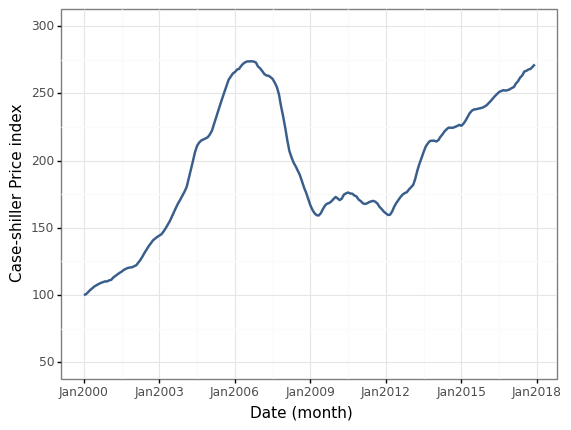

<ggplot: (316388250)>

In [13]:
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)
breaks = date_breaks("1 year")

price_index_plot = (
    ggplot(data, aes(x="date", y="p", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[50, 300], breaks=seq(50, 301, 50))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Case-shiller Price index", x="Date (month)")
    + theme_bw()
)
price_index_plot

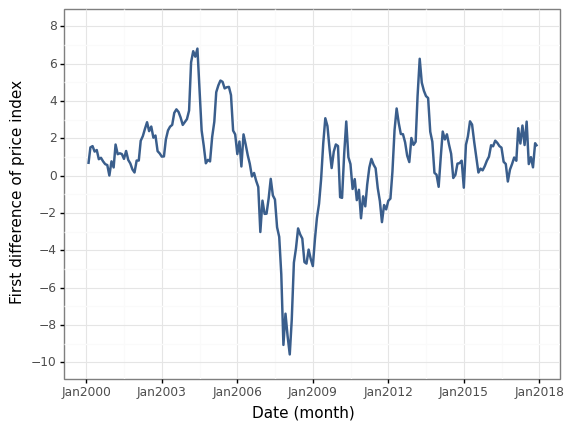

<ggplot: (316443408)>

In [14]:
# additional graphs, not in textbook
# Plot log difference of price index

dp_plot = (
    ggplot(data, aes(x="date", y="dp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[-10, 8], breaks=seq(-10, 9, 2))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="First difference of price index", x="Date (month)")
    + theme_bw()
)
dp_plot

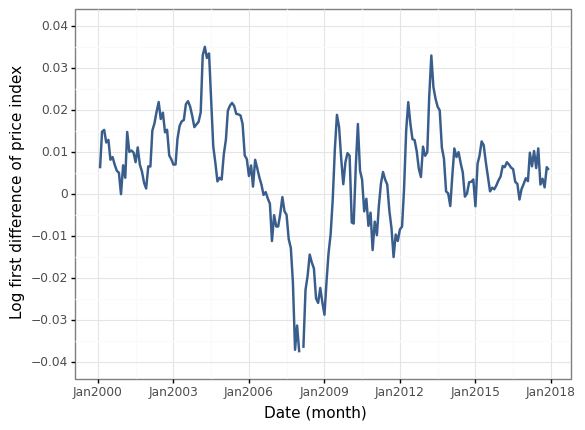

<ggplot: (316490611)>

In [15]:
# Plot log difference of price index
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)
breaks = date_breaks("1 year")

dlnp_plot = (
    ggplot(data, aes(x="date", y="dlnp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[-0.04, 0.04], breaks=seq(-0.04, 0.05, 0.01))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Log first difference of price index", x="Date (month)")
    + theme_bw()
)
dlnp_plot

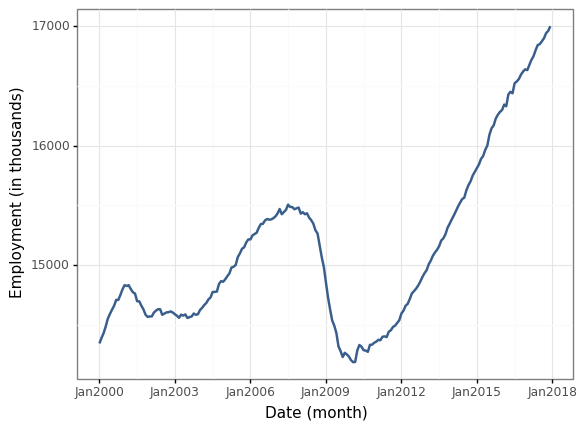

<ggplot: (316540341)>

In [16]:
## Figure 18.10

# additional graphs, not in textbook
# Plot log difference of price index

emp_plot = (
    ggplot(data, aes(x="date", y="emp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Employment (in thousands)", x="Date (month)")
    + theme_bw()
)
emp_plot

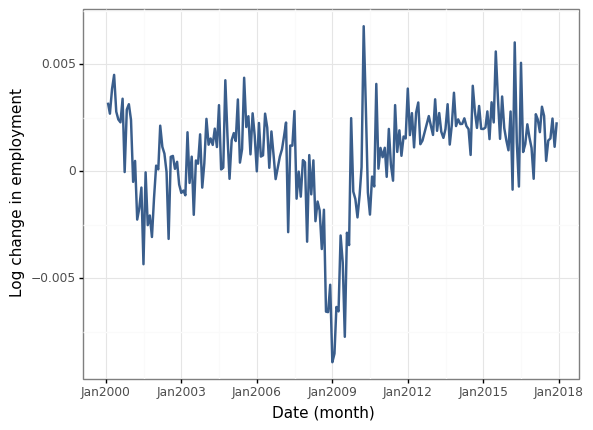

<ggplot: (277114281)>

In [17]:
# Plot log diff employment
lnemp_plot = (
    ggplot(data, aes(x="date", y="dlnemp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Log change in employment", x="Date (month)")
    + theme_bw()
)

lnemp_plot

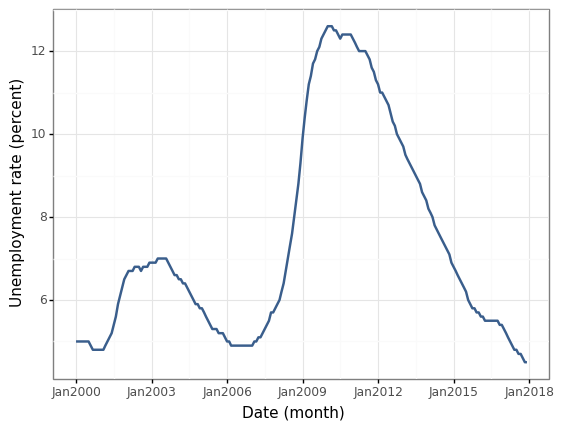

<ggplot: (316601914)>

In [18]:
# Plot unemployment rate
u_plot = (
    ggplot(data, aes(x="date", y="u", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Unemployment rate (percent)", x="Date (month)")
    + theme_bw()
)

u_plot

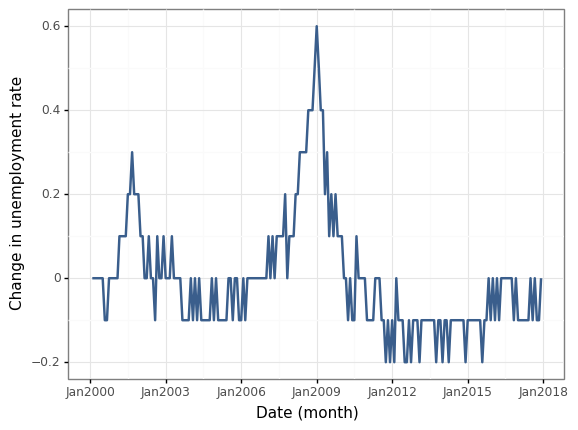

<ggplot: (316592514)>

In [19]:
# Plot diff unemployment

du_plot = (
    ggplot(data, aes(x="date", y="du", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Change in unemployment rate", x="Date (month)")
    + theme_bw()
)

du_plot

### Create work set and holdout set

In [20]:
from datetime import datetime
data["date"] = data["date"].apply(lambda x: datetime.strptime(x, "%Y-%m"))

In [21]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2017, :]
data_work = data.loc[lambda x: x["year"] < 2017, :]

In [22]:
# create training and test sets for 4 folds

for year in range(2013, 2017):
    fold = year - 2012
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (
        data_work["year"] >= year - 13
    )

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

In [24]:
# Model M1
# p on trend & seasonality
mse_1 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model1 = smf.ols("p ~ trend + C(month)", train_data).fit()

    phat = model1.predict(test_data)

    errsq = np.square(test_data.p.values - phat)

    mse_1.append(np.mean(errsq))

rmse_cv_m1 = np.sqrt(np.mean(mse_1))

In [25]:
# Model M2
# p ARIMA(1,1,2)

mse_2 = []

for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]
    
    model2 = ARIMA(train_data.p, order=(1, 1, 2)).fit()

    phat = model2.forecast(steps=12)

    errsq = np.square(test_data.p.values - phat)

    mse_2.append(np.mean(errsq))

rmse_cv_m2 = np.sqrt(np.mean(mse_2))

In [26]:
# Model M3
# p ARIMA(1,1,0)

mse_3 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model3 = ARIMA(
        train_data.p, exog=pd.get_dummies(train_data.month), order=(1, 1, 0)
    ).fit()

    phat = model3.forecast(steps=12, exog=pd.get_dummies(test_data.month))

    errsq = np.square(test_data.p.values - phat)

    mse_3.append(np.mean(errsq))

rmse_cv_m3 = np.sqrt(np.mean(mse_3))

In [27]:
# Model M4
# p ARIMA(2,0,0) + seasonality + trend

mse_4 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model4 = ARIMA(
        train_data.p, exog=pd.get_dummies(train_data.month), trend="t", order=(2, 0, 0)
    ).fit()

    phat = model4.forecast(steps=12, exog=pd.get_dummies(test_data.month), trend="t")

    errsq = np.square(test_data.p.values - phat)

    mse_4.append(np.mean(errsq))

rmse_cv_m4 = np.sqrt(np.mean(mse_4))

In [28]:
# Model M5
# dp ~ month + trend, without any ARIMA
mse_5 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model5 = smf.ols("dp ~ trend + C(month)", train_data).fit()

    dphat = model5.predict(test_data)

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat.iloc[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat.iloc[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_5.append(np.mean(errsq))

rmse_cv_m5 = np.sqrt(np.mean(mse_5))

In [29]:
# Model M6
# lnp ARIMA(0,2,0) + seasonality

mse_6 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model6 = ARIMA(
        train_data.lnp, exog=pd.get_dummies(train_data.month), order=(0, 2, 0)
    ).fit()

    lnphat = model6.forecast(steps=12, exog=pd.get_dummies(test_data.month))
    
    corrb = mean_squared_error(test_data.lnp , lnphat)

    phat = np.exp((lnphat + corrb / 2))

    errsq = np.square(test_data.p.values - phat)

    mse_6.append(np.mean(errsq))

rmse_cv_m6 = np.sqrt(np.mean(mse_6))

In [30]:
# VAR

mse_var = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model7 = VAR(train_data[["dp", "du", "dlnemp"]]).fit(1)

    dphat = model7.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model7.k_ar :], steps=12
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_var.append(np.mean(errsq))

rmse_cv_m7 = np.sqrt(np.mean(mse_var))

In [31]:
# Note. This VAR includes month dummies
# Textbook results are from R, where 
# we could not figure out how to inlcude month dummies

mse_var = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model7 = VAR(
        train_data[["dp", "du", "dlnemp"]], exog=pd.get_dummies(train_data["month"])
    ).fit(1)

    dphat = model7.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model7.k_ar :],
        exog_future=pd.get_dummies(test_data["month"]).values,
        steps=12,
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_var.append(np.mean(errsq))

rmse_cv_m7 = np.sqrt(np.mean(mse_var))

In [32]:
pd.DataFrame(
    [mse_1, mse_2, mse_3, mse_4, mse_5, mse_6, mse_var],
    columns=["Fold" + str(i) for i in range(1, 5)],
).apply(np.sqrt).assign(
    Average=[
        rmse_cv_m1,
        rmse_cv_m2,
        rmse_cv_m3,
        rmse_cv_m4,
        rmse_cv_m5,
        rmse_cv_m6,
        rmse_cv_m7,
    ],
    model=["M" + str(i) for i in range(1, 8)],
).round(
    2
).set_index(
    "model"
)

,Fold1,Fold2,Fold3,Fold4,Average
model,,,,,
M1,14.90,17.59,34.43,48.58,31.93
M2,14.82,8.39,6.23,5.53,9.48
M3,6.68,1.39,3.28,3.22,4.11
M4,3.00,1.24,1.37,2.05,2.04
M5,33.94,9.79,10.42,7.39,18.78
M6,2.52,4.92,9.31,9.73,7.28
M7,5.69,1.85,5.05,4.57,4.53


### predict for holdout

In [33]:
# best model is M4
# re-estimate best models on full work set
model_final = ARIMA(
    data_work.p, exog=pd.get_dummies(data_work.month), trend="t", order=(2, 0, 0)
).fit()

In [34]:
pred_final = model_final.get_forecast(
    steps=12, exog=pd.get_dummies(data_holdout.month), trend="t"
)

In [35]:
forecast_holdout_best = (
    data_holdout.assign(p_pred=pred_final.predicted_mean.values, model="best")
    .join(pred_final.conf_int(alpha=0.2))
    .filter(["model", "p_pred", "lower p", "upper p"])
)

In [36]:
data_plot = data.join(forecast_holdout_best).loc[lambda x: x.year >= 2015]

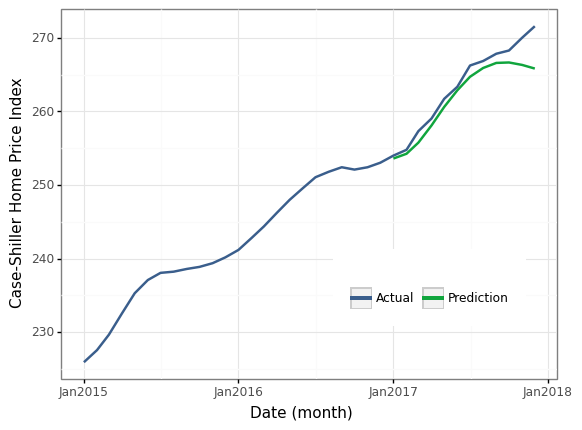

<ggplot: (316304303)>

In [37]:
data_plot_1 = pd.melt(data_plot.filter(["date","p","p_pred"]),["date"])

pred_p_plot = (
    ggplot(data_plot_1, aes(x="date", y="value", color="variable"))
    + geom_line(size=1)
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + scale_color_manual(
        name=" ", values=(color[0], color[1]), labels=("Actual", "Prediction")
    )
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
    + theme_bw()
    + theme(legend_position=(0.7, 0.3), legend_direction="horizontal")
)
pred_p_plot

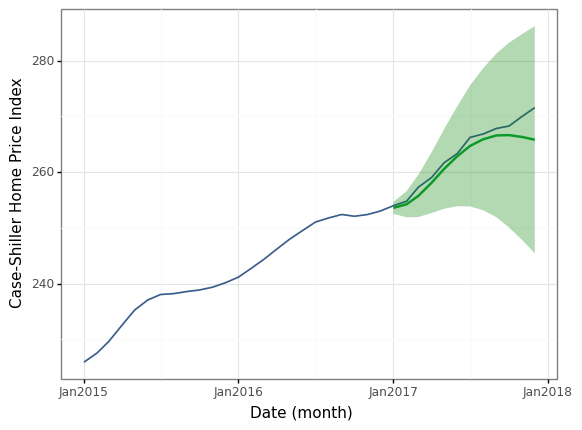

<ggplot: (318778932)>

In [38]:
pred_p_plot = (
    ggplot(data_plot, aes(x="date"))
    + geom_line(aes(y="p"), color=color[0], size=0.7)
    + geom_line(aes(y="p_pred"), color=color[1], size=1)
    + geom_line(aes(y="lower p"), color=color[1], size=0)
    + geom_line(aes(y="upper p"), color=color[1], size=0)
    + geom_ribbon(aes(ymin="lower p", ymax="upper p"), fill="green", alpha=0.3)
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + theme_bw()
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
)
pred_p_plot

In [39]:
errsq = np.square(data_holdout.p.values - forecast_holdout_best.p_pred)

rmse_holdout = np.mean(errsq)
rmse_holdout

4.950026065550111

### EXTERNAL VALIDITY
### do the prediction for an extra year

In [40]:
data = pd.read_pickle("case-shiller-workfile-2000-2018.pkl")

In [41]:
data["date"] = data["date"].apply(lambda x: datetime.strptime(x, "%Y-%m"))

In [42]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2018, :]
data_work = data.loc[lambda x: x["year"] < 2018, :]

In [43]:
# best model is M4
# re-estimate best models on full work set
model_final = ARIMA(
    data_work.p, exog=pd.get_dummies(data_work.month), trend="t", order=(2, 0, 0)
).fit()

In [44]:
pred_final = model_final.get_forecast(
    steps=12, exog=pd.get_dummies(data_holdout.month), trend="t"
)

In [45]:
forecast_holdout_best = (
    data_holdout.assign(p_pred=pred_final.predicted_mean.values, model="best")
    .join(pred_final.conf_int(alpha=0.2))
    .filter(["model", "p_pred", "lower p", "upper p"])
)

In [46]:
data_plot = data.join(forecast_holdout_best).loc[lambda x: x.year >= 2015]

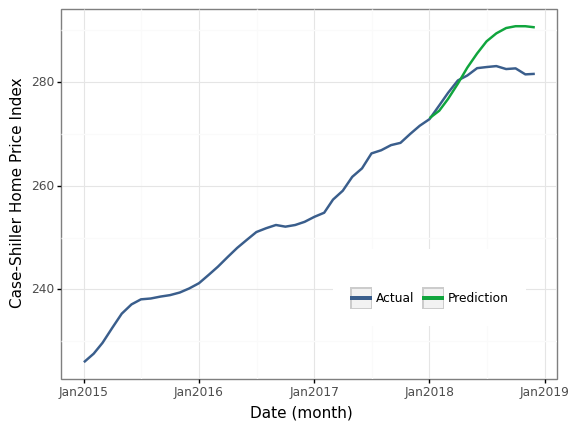

<ggplot: (316350579)>

In [47]:
data_plot_1 = pd.melt(data_plot.filter(["date","p","p_pred"]),["date"])

pred_p_plot = (
    ggplot(data_plot_1, aes(x="date", y="value", color="variable"))
    + geom_line(size=1)
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + scale_color_manual(
        name=" ", values=(color[0], color[1]), labels=("Actual", "Prediction")
    )
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
    + theme_bw()
    + theme(legend_position=(0.7, 0.3), legend_direction="horizontal")
)
pred_p_plot

## Figure 18.11 Prediction on new holdout

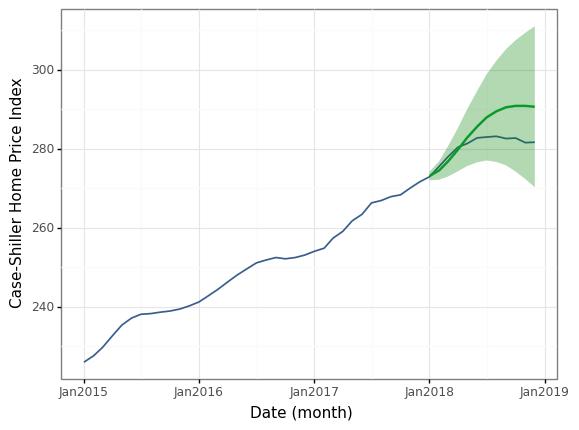

<ggplot: (318815419)>

In [48]:
pred_p_plot = (
    ggplot(data_plot, aes(x="date"))
    + geom_line(aes(y="p"), color=color[0], size=0.7)
    + geom_line(aes(y="p_pred"), color=color[1], size=1)
    + geom_line(aes(y="lower p"), color=color[1], size=0)
    + geom_line(aes(y="upper p"), color=color[1], size=0)
    + geom_ribbon(aes(ymin="lower p", ymax="upper p"), fill="green", alpha=0.3)
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + theme_bw()
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
)
pred_p_plot

In [49]:
errsq = np.square(data_holdout.p.values - forecast_holdout_best.p_pred)

rmse_holdout = np.mean(errsq)
rmse_holdout

31.16075604629928